# Code pour le travail de bachelor

---
### Installation de la librairie z3 sur le notebook si pas encore fait

In [ ]:
pip install z3-solver

---
### Tests initiaux

Essai d'un solver simple avec ajout de la dernière solution pour obtenir tous les résultats possibles.

In [1]:
from z3 import *

#Variables
x = Int('x')
y = Int('y')

#Solver
solver = Solver()

#Conditions initales
solver.add( x + y == 10 , x >= 0 , y >= 0)

#Boucle pour afficher et rajouter la dernière solution
while solver.check() == sat :
    model = solver.model()
    print(model)
    blocks = []
    for d in model :
        cp = model[d] == d()
        blocks.append(cp)
        
    solver.add( Not ( And ( blocks )))
    #print(solver)


[y = 0, x = 10]
[x = 9, y = 1]
[x = 8, y = 2]
[x = 7, y = 3]
[x = 6, y = 4]
[x = 5, y = 5]
[x = 4, y = 6]
[x = 3, y = 7]
[x = 2, y = 8]
[x = 1, y = 9]
[x = 0, y = 10]


Formules/conditions à ajouter dans nos solver manuellement (stocké ici pour réutiliser facilement)

In [ ]:
#conditions à ajouter dans le solver

#vitesse   s[voiture][temps]
s[i][0] == x

#freinage  df[voiture][temps]
df[i][0] == (s[i][0]*(s[i][0] + 1)) / 2
    

---
### Affichage d'une solution avec des conditions semblables à notre version utile :

Pas possible d'avoir l'infini donc on met un nombre arbitrairement grand [Lien Z3Py](https://ericpony.github.io/z3py-tutorial/guide-examples.htm)

In [7]:
from z3 import *

#n voitures et t temps max
n = 2
t = 3

#Variables
infini = 10000000
vmax = 6
distancemax = 100000

s = [[Int('s_{}_{}'.format(i, j)) for j in range(t)] for i in range(n)] #vitesse_[voiture]_[temps]
pos = [[Int('pos_{}_{}'.format(i, j)) for j in range(t)] for i in range(n)] #position_[voiture]_[temps]

df = [[Int('df_{}_{}'.format(i, j)) for j in range(t)] for i in range(n)] #distance freinage_[voiture]_[temps]

#distance entre 2 voitures (de i à j) au temps k
d = [[[Int('d_{}_{}_{}'.format(i, j, k)) for k in range(t)] for j in range(n)] for i in range(n)] 


#Solver
solver = Solver()

#conditions initiales
#solver.add(pos[0][0] == 3, s[0][0] == 2, pos[1][0] == 6, s[1][0] == 1, pos[2][0] == 0, s[2][0] == 0) #position + vitesse

#condition pour la distance de freinage initiale
for i in range(n) :
    solver.add(pos[i][0] >= 0, pos[i][0] <= distancemax) #position initiale positive
    solver.add(s[i][0] >= 0, s[i][0] <= vmax) #vitesse initiale bornée
    solver.add(df[i][0] == (s[i][0] * (s[i][0] + 1)) / 2) #distance freinage

#Modifations de vitesses et positions
for time in range(1, t) :
    for i in range(n) :
        #modification de la vitesse (+/- 1 ou constante)
        solver.add( Or( s[i][time] == s[i][time - 1],
                          s[i][time] == s[i][time - 1] + 1,
                          s[i][time] == s[i][time - 1] - 1)) 
        
        solver.add(pos[i][time] == pos[i][time-1] + s[i][time-1]) #position = pos(t-1) + vitesse(t-1)
        solver.add(df[i][time] == (s[i][time] * (s[i][time] + 1)) / 2) #distance freinage
        
        #vitesse et position toujours positive ou nulle
        solver.add(s[i][time] >= 0, s[i][time] <= vmax)
        solver.add(pos[i][time] >= 0, pos[i][time] <= distancemax)

#calcul distance entre voitures + conditions à satisfaire
for time in range(t) :
    for i in range(n) :
        for j in range(n) :
            #calcul d'écart entre les voitures (+infini si derrière ou même voiture pour satisfaire les conditions suivantes)
            solver.add( Or( 
                            And( d[i][j][time] == pos[j][time] - pos[i][time] - 1, pos[j][time] - pos[i][time] > 0 )
                            , And( d[i][j][time] == infini, pos[j][time] - pos[i][time] <= 0) ) )
            
            #conditions à satisfaire en tout temps
            solver.add( d[i][j][time] + df[j][time] >= df[i][time] ) #distance de sécurité
            if (i != j) :
                solver.add( pos[i][time] != pos[j][time] ) #pas de voitures à la même position

#conditions finales
for i in range(n) :
    for j in range(n) :
        #ajoute la condition initiale si i est derrière j (rien autrement)
        solver.add( Or( d[i][j][0] == infini,
                        And( s[i][0] > d[i][j][0],  d[i][j][0] != infini ))) #condition initial ne satisfait pas la condition final
        
        solver.add( s[i][t-1] <= d[i][j][t-1] ) #au temps final
        
        #ajoute la condition finale d'une vitesse non nulle
        solver.add( s[i][t-1] == vmax )


#print(solver)
#model = Optimize()
#model.minimize(...)
"""
while solver.check() == sat :
    model = solver.model()
    print(model)
    blocks = []
    for d in model :
        cp = model[d] == d()
        blocks.append(Not(cp))
        
    solver.add( Or ( blocks ))
    """
if solver.check() == sat :
    model = solver.model()
    
    # Obtenir les variables du modèle
    variables = model.decls()
    
    # Trier les variables par leur nom
    sorted_variables = sorted(variables, key = lambda v : v.name())
    
    # Afficher les valeurs des variables dans l'ordre
    for var in sorted_variables:
        print(f"{var.name()} : {model[var]}")
else :
    print("\nPas de solutions !")

d_0_0_0 : 10000000
d_0_0_1 : 10000000
d_0_0_2 : 10000000
d_0_1_0 : 10000000
d_0_1_1 : 10000000
d_0_1_2 : 10000000
d_1_0_0 : 4
d_1_0_1 : 5
d_1_0_2 : 6
d_1_1_0 : 10000000
d_1_1_1 : 10000000
d_1_1_2 : 10000000
df_0_0 : 21
df_0_1 : 21
df_0_2 : 21
df_1_0 : 15
df_1_1 : 15
df_1_2 : 21
pos_0_0 : 99988
pos_0_1 : 99994
pos_0_2 : 100000
pos_1_0 : 99983
pos_1_1 : 99988
pos_1_2 : 99993
s_0_0 : 6
s_0_1 : 6
s_0_2 : 6
s_1_0 : 5
s_1_1 : 5
s_1_2 : 6


---
### Simulation de rétrécissement de route

On défini $n$ qui indique le nombre de voitures, $t$ pour le nombre de temps pour résoudre notre problème.

> $ v_{max} = 6$ signifie que la vitesse maximum qu'une voiture puisse avoir est de 6. 
>
> $s\_i\_t$ indique la vitesse de la voiture $i$ au temps $t$.
> 
> $pos\_i\_t$ indique la position de la voiture $i$ au temps $t$.
>
> $df\_i\_t$ indique la distance de freinage de la voiture $i$ au temps $t$.
>
> $d\_i\_j\_t$ indique la distance entre la voiture $i$ et la voiture $j$ au temps $t$.

On pose comme conditions initiales :

- La position des voitures est toujours positive : $pos[i][0] \geq 0$, $\forall i$

- La vitesse des voitures est compris entre 0 et $v_{max} - 1$ (on interdit d'avoir la vitesse maximum pour avoir des cas plus généraux) : $ 0 \leq s[i][0] \leq v_{max} - 1$, $\forall i$

- On défini la distance de freinage comme : $ df[i][0] = \frac{s[i][0] * (s[i][0] + 1)}{2}$, $\forall i$

Ensuite on définit les modification de variables possibles :

- Pour la vitesse, soit elle reste constante, soit elle augmente ou diminue de 1 toujours en restant dans les bornes :

>$ 0 \leq s[i][t] \leq v_{max}$              , $\forall i$ et $\forall {t > 0}$
>
>$ s[i][t] = (s[i][t - 1]) \vee (s[i][t - 1] - 1) \vee (s[i][t - 1] + 1)$          , $\forall i$ et $\forall {t > 0}$

- La position dépend de la position précédente et de la vitesse de la voiture :

> $ pos[i][t] = pos[i][t - 1] + s[i][t - 1]$ , $\forall i$ et $\forall {t > 0}$

- La distance de freinage garde la même formule pour les temps suivants :

> $ df[i][t] = \frac{s[i][t] * (s[i][t] + 1)}{2}$, $\forall i$ et $\forall {t > 0}$

Maintenant on va définir des conditions qui vont permettre de simuler les conditions souhaitées. Pour simplifier l'écriture et la lecture des résultats, on commence par définir que les voitures sont dans l'ordre croissant :

> $pos[i][t] < pos[i + 1][t]$ , $\forall i < n$ et $\forall t$

Grâce à cela, on peut définir la distance entre 2 voitures qui se suivent :

> $d[i][i + 1][t] = pos[i + 1][t] - pos[i][t] - 1$ , $\forall i < n$ et $\forall t$

Et de définir une condition à satisfaire en tout temps, La distance entre 2 voiture plus la distance de freinage de la voiture de devant doit être supérieur ou égal à la distance de freinage de la voiture de derrière pour éviter tout accident :

> $d[i][i + 1][t] + df[i + 1][t] \geq df[i][t]$ , $\forall i < n$ et $\forall t$

Enfin, on définit les conditions finales (et des restictions initiales qui ne satisfont pas les conditions finales) afin de voir si un résultat est possible.

On souhaite avoir une vitesse finale inférieur ou égal à la distance entre cette voiture et celle de devant :

> $s[i][t_{max}] \leq d[i][i + 1][t_{max}]$ , $\forall i < n$
>
> On ajoute donc la condition initale qui ne satisfait pas cette règle :
>
> $s[i][0] > d[i][i + 1][0]$ , $\forall i < n$

Et afin d'avoir un résultat optimal, on s'assure que toutes les voitures aient repris leur vitesse maximum :

> $ s[i][t_{max}] = v_{max}$ , $\forall i$

In [3]:
from z3 import *

#n voitures et t temps max
n = 2
t = 50

#Variables
vmax = 6

s = [[Int('s_{}_{}'.format(i, j)) for j in range(t)] for i in range(n)] #vitesse_[voiture]_[temps]
pos = [[Int('pos_{}_{}'.format(i, j)) for j in range(t)] for i in range(n)] #position_[voiture]_[temps]

df = [[Int('df_{}_{}'.format(i, j)) for j in range(t)] for i in range(n)] #distance freinage_[voiture]_[temps]

#distance entre 2 voitures (de i à j) au temps k
d = [[[Int('d_{}_{}_{}'.format(i, j, k)) for k in range(t)] for j in range(n)] for i in range(n)] 


#Solver
solver = Solver()

#condition initiale
solver.add(pos[0][0] == 0)
for i in range(n) :
    solver.add(pos[i][0] >= 0) #position initiale positive
    solver.add(s[i][0] >= 0, s[i][0] <= vmax - 1) #vitesse initiale bornée
    solver.add(df[i][0] == (s[i][0] * (s[i][0] + 1)) / 2) #distance freinage

#Modifations de vitesses et positions
for time in range(1, t) :
    for i in range(n) :
        #vitesse toujours bornée
        solver.add(s[i][time] >= s[i][time - 1])
        solver.add(s[i][time] >= 0, s[i][time] <= vmax)
        #modification de la vitesse (+/- 1 ou constante)
        solver.add( Or( s[i][time] == s[i][time - 1],
                          s[i][time] == s[i][time - 1] + 1,
                          s[i][time] == s[i][time - 1] - 1)) 
        
        solver.add(pos[i][time] == pos[i][time-1] + s[i][time-1]) #position = pos(t-1) + vitesse(t-1)
        solver.add(df[i][time] == (s[i][time] * (s[i][time] + 1)) / 2) #distance freinage
        

#calcul distance entre voitures + conditions à satisfaire
for time in range(t) :
    for i in range(n - 1) :
        solver.add( pos[i][time] < pos[i + 1][time] ) #si i<j alors i est derrière j
        #calcul d'écart entre les voitures 
        solver.add( d[i][i + 1][time] == pos[i + 1][time] - pos[i][time] - 1)
        
        #conditions à satisfaire en tout temps
        solver.add( d[i][i + 1][time] + df[i + 1][time] >= df[i][time] ) #distance de sécurité

            

#conditions finales
for i in range(n) :
    if (i != n - 1) :
        #ajoute la condition initiale si i est derrière j (rien autrement)
        solver.add( s[i][0] > d[i][i + 1][0] ) #condition initial ne satisfait pas la condition final

        solver.add( s[i][t-1] <= d[i][i + 1][t-1] ) #au temps final
        
    #ajoute la condition finale d'une vitesse max
    solver.add( s[i][t-1] == vmax )
    
#affichage du résultat
if solver.check() == sat :
    model = solver.model()
    
    # Obtenir les variables du modèle
    variables = model.decls()
    
    # Trier les variables par leur nom
    sorted_variables = sorted(variables, key = lambda v : v.name())
    
    # Afficher les valeurs des variables dans l'ordre
    for var in sorted_variables:
        print(f"{var.name()} : {model[var]}")
else :
    print("\nPas de solutions !")

d_0_1_0 : 0
d_0_1_1 : 2
d_0_1_10 : 26
d_0_1_11 : 31
d_0_1_12 : 36
d_0_1_13 : 41
d_0_1_14 : 46
d_0_1_15 : 51
d_0_1_16 : 56
d_0_1_17 : 61
d_0_1_18 : 66
d_0_1_19 : 71
d_0_1_2 : 4
d_0_1_20 : 76
d_0_1_21 : 81
d_0_1_22 : 86
d_0_1_23 : 91
d_0_1_24 : 96
d_0_1_25 : 101
d_0_1_26 : 106
d_0_1_27 : 111
d_0_1_28 : 116
d_0_1_29 : 121
d_0_1_3 : 6
d_0_1_30 : 126
d_0_1_31 : 131
d_0_1_32 : 136
d_0_1_33 : 141
d_0_1_34 : 146
d_0_1_35 : 151
d_0_1_36 : 156
d_0_1_37 : 161
d_0_1_38 : 166
d_0_1_39 : 171
d_0_1_4 : 8
d_0_1_40 : 176
d_0_1_41 : 181
d_0_1_42 : 186
d_0_1_43 : 191
d_0_1_44 : 196
d_0_1_45 : 201
d_0_1_46 : 205
d_0_1_47 : 208
d_0_1_48 : 210
d_0_1_49 : 211
d_0_1_5 : 10
d_0_1_6 : 12
d_0_1_7 : 14
d_0_1_8 : 17
d_0_1_9 : 21
df_0_0 : 1
df_0_1 : 1
df_0_10 : 1
df_0_11 : 1
df_0_12 : 1
df_0_13 : 1
df_0_14 : 1
df_0_15 : 1
df_0_16 : 1
df_0_17 : 1
df_0_18 : 1
df_0_19 : 1
df_0_2 : 1
df_0_20 : 1
df_0_21 : 1
df_0_22 : 1
df_0_23 : 1
df_0_24 : 1
df_0_25 : 1
df_0_26 : 1
df_0_27 : 1
df_0_28 : 1
df_0_29 : 1
df_0_3 : 1
df_0_3

---
### Test avec la fonction Optimize() :

On ne l'utilisera pas par la suite car n'apporte rien d'intéressant pour notre problème.

In [ ]:
from z3 import *

#n voitures et t temps max
n = 2
t = 50

#Variables
vmax = 6

s = [[Int('s_{}_{}'.format(i, j)) for j in range(t)] for i in range(n)] #vitesse_[voiture]_[temps]
pos = [[Int('pos_{}_{}'.format(i, j)) for j in range(t)] for i in range(n)] #position_[voiture]_[temps]

df = [[Int('df_{}_{}'.format(i, j)) for j in range(t)] for i in range(n)] #distance freinage_[voiture]_[temps]

#distance entre 2 voitures (de i à j) au temps k
d = [[[Int('d_{}_{}_{}'.format(i, j, k)) for k in range(t)] for j in range(n)] for i in range(n)] 

# Optimiseur
optimizer = Optimize()

# Condition initiale
for i in range(n):
    optimizer.add(pos[0][0] == 0)
    optimizer.add(pos[i][0] >= 0) #position initiale positive
    optimizer.add(s[i][0] >= 0, s[i][0] <= vmax - 1) #vitesse initiale bornée
    optimizer.add(df[i][0] == (s[i][0] * (s[i][0] + 1)) / 2) #distance freinage

# Modifations de vitesses et positions
for time in range(1, t):
    for i in range(n):
        optimizer.add(s[i][time] >= 0, s[i][time] <= vmax) #vitesse bornée
        optimizer.add( Or( s[i][time] == s[i][time - 1],
                          s[i][time] == s[i][time - 1] + 1,
                          s[i][time] == s[i][time - 1] - 1)) #modification de vitesse
        optimizer.add(pos[i][time] == pos[i][time-1] + s[i][time-1]) #position = pos(t-1) + vitesse(t-1)
        optimizer.add(df[i][time] == (s[i][time] * (s[i][time] + 1)) / 2) #distance freinage

# Calcul distance entre voitures + conditions à satisfaire
for time in range(t):
    for i in range(n - 1):
        optimizer.add(pos[i][time] < pos[i + 1][time]) #si i<j alors i est derrière j
        optimizer.add(d[i][i + 1][time] == pos[i + 1][time] - pos[i][time] - 1) #calcul d'écart
        optimizer.add(d[i][i + 1][time] + df[i + 1][time] >= df[i][time]) #distance de sécurité

# Conditions finales
for i in range(n):
    if (i != n - 1):
        optimizer.add(s[i][0] > d[i][i + 1][0]) #ajoute la condition initiale si i est derrière j
        optimizer.add(s[i][t-1] <= d[i][i + 1][t-1]) #au temps final
    optimizer.add(s[i][t-1] == vmax) #ajoute la condition finale d'une vitesse max

# Définir une fonction objectif : minimiser le temps total
total_time = Sum([If(s[i][j] == vmax, 0, 1) for i in range(n) for j in range(t)]) # somme des temps nécessaires pour chaque voiture

# Ajouter la fonction objectif à l'optimiseur
optimizer.minimize(total_time)

#affichage du résultat
if optimizer.check() == sat :
    model = optimizer.model()
    
    # Obtenir les variables du modèle
    variables = model.decls()
    
    # Trier les variables par leur nom
    sorted_variables = sorted(variables, key = lambda v : v.name())
    
    # Afficher les valeurs des variables dans l'ordre
    for var in sorted_variables:
        print(f"{var.name()} : {model[var]}")
else :
    print("\nPas de solutions !")


---
### Utilisation du Solver() dans une boucle pour varier le nombre de voitures et le temps

Dans cette partie la vitesse peut diminuer et les valeurs pertinante sont stockées dans des dictionnaires :

> $dico\_vitesse\_pas\_restreint$ contient un dictionnaire avec comme clé : le nombre de voitures et comme valeur : le temps minimum pour résoudre le problème.

> $dico\_vitesses\_voitures[k][l][m]$ contient les vitesses pour $k$ voitures, pour la voiture numéro $l$ au temps $m$. 

In [1]:
from z3 import *

dico_vitesse_pas_restreint = {}
dico_vitesses_voitures = {}
for k in range(2, 11) :
    dico_vitesse_pas_restreint[k] = 100000000
    dico_vitesses_voitures[k] = {}
    for m in range(k) :
        dico_vitesses_voitures[k][m] = {}
    for l in range(2, 300) :
        #n voitures et t temps max
        n = k
        t = l

        #Variables
        vmax = 6

        s = [[Int('s_{}_{}'.format(i, j)) for j in range(t)] for i in range(n)] #vitesse_[voiture]_[temps]
        pos = [[Int('pos_{}_{}'.format(i, j)) for j in range(t)] for i in range(n)] #position_[voiture]_[temps]

        df = [[Int('df_{}_{}'.format(i, j)) for j in range(t)] for i in range(n)] #distance freinage_[voiture]_[temps]

        #distance entre 2 voitures (de i à j) au temps k
        d = [[[Int('d_{}_{}_{}'.format(i, j, k)) for k in range(t)] for j in range(n)] for i in range(n)] 


        #Solver
        solver = Solver()

        #condition initiale
        solver.add(pos[0][0] == 0) #1ere voiture à la 1ere position
        for i in range(n) :
            solver.add(pos[i][0] >= 0) #position initiale positive
            solver.add(s[i][0] >= 0, s[i][0] <= vmax - 1) #vitesse initiale bornée
            solver.add(df[i][0] == (s[i][0] * (s[i][0] + 1)) / 2) #distance freinage

        #Modifations de vitesses et positions
        for time in range(1, t) :
            for i in range(n) :
                #vitesse toujours bornée
                solver.add(s[i][time] >= 0, s[i][time] <= vmax)
                #modification de la vitesse (+/- 1 ou constante)
                solver.add( Or( s[i][time] == s[i][time - 1],
                                  s[i][time] == s[i][time - 1] + 1,
                                  s[i][time] == s[i][time - 1] - 1)) 

                solver.add(pos[i][time] == pos[i][time-1] + s[i][time-1]) #position = pos(t-1) + vitesse(t-1)
                solver.add(df[i][time] == (s[i][time] * (s[i][time] + 1)) / 2) #distance freinage


        #calcul distance entre voitures + conditions à satisfaire
        for time in range(t) :
            for i in range(n - 1) :
                solver.add( pos[i][time] < pos[i + 1][time] ) #si i<j alors i est derrière j
                #calcul d'écart entre les voitures 
                solver.add( d[i][i + 1][time] == pos[i + 1][time] - pos[i][time] - 1)

                #conditions à satisfaire en tout temps
                solver.add( d[i][i + 1][time] + df[i + 1][time] >= df[i][time] ) #distance de sécurité



        #conditions finales
        for i in range(n) :
            if (i != n - 1) :
                #ajoute la condition initiale si i est derrière j (rien autrement)
                solver.add( s[i][0] > d[i][i + 1][0] ) #condition initial ne satisfait pas la condition final

                solver.add( s[i][t-1] <= d[i][i + 1][t-1] ) #au temps final

            #ajoute la condition finale d'une vitesse max
            solver.add( s[i][t-1] == vmax )

        #affichage du résultat
        if solver.check() == sat :
            model = solver.model()

            # Obtenir les variables du modèle
            variables = model.decls()

            # Trier les variables par leur nom
            sorted_variables = sorted(variables, key = lambda v : v.name())

            # Afficher les valeurs des variables dans l'ordre
            #"""
            print(f"\n\nPour {k} voitures : \n")
            for var in sorted_variables :
                print(f"{var.name()} : {model[var]}")
                if (var.name()[:2] == "s_") :
                    if (len(var.name()) == 5) :
                        dico_vitesses_voitures[k][int(var.name()[2])][int(var.name()[4])] = model[var]
                    else :
                        dico_vitesses_voitures[k][int(var.name()[2])][int(var.name()[4:5])] = model[var]
            
            #"""
            dico_vitesse_pas_restreint[k] = l
            break
        else :
            #print("\nPas de solutions !")
            wfwec = 3
            
print(dico_vitesse_pas_restreint)
print(dico_vitesses_voitures)



Pour 2 voitures : 

d_0_1_0 : 4
d_0_1_1 : 4
d_0_1_2 : 6
d_0_1_3 : 6
df_0_0 : 15
df_0_1 : 10
df_0_2 : 15
df_0_3 : 21
df_1_0 : 15
df_1_1 : 21
df_1_2 : 15
df_1_3 : 21
pos_0_0 : 0
pos_0_1 : 5
pos_0_2 : 9
pos_0_3 : 14
pos_1_0 : 5
pos_1_1 : 10
pos_1_2 : 16
pos_1_3 : 21
s_0_0 : 5
s_0_1 : 4
s_0_2 : 5
s_0_3 : 6
s_1_0 : 5
s_1_1 : 6
s_1_2 : 5
s_1_3 : 6


Pour 3 voitures : 

d_0_1_0 : 2
d_0_1_1 : 4
d_0_1_2 : 5
d_0_1_3 : 6
d_0_1_4 : 6
d_1_2_0 : 4
d_1_2_1 : 4
d_1_2_2 : 6
d_1_2_3 : 6
d_1_2_4 : 6
df_0_0 : 6
df_0_1 : 6
df_0_2 : 10
df_0_3 : 15
df_0_4 : 21
df_1_0 : 15
df_1_1 : 10
df_1_2 : 15
df_1_3 : 15
df_1_4 : 21
df_2_0 : 15
df_2_1 : 21
df_2_2 : 15
df_2_3 : 15
df_2_4 : 21
pos_0_0 : 0
pos_0_1 : 3
pos_0_2 : 6
pos_0_3 : 10
pos_0_4 : 15
pos_1_0 : 3
pos_1_1 : 8
pos_1_2 : 12
pos_1_3 : 17
pos_1_4 : 22
pos_2_0 : 8
pos_2_1 : 13
pos_2_2 : 19
pos_2_3 : 24
pos_2_4 : 29
s_0_0 : 3
s_0_1 : 3
s_0_2 : 4
s_0_3 : 5
s_0_4 : 6
s_1_0 : 5
s_1_1 : 4
s_1_2 : 5
s_1_3 : 5
s_1_4 : 6
s_2_0 : 5
s_2_1 : 6
s_2_2 : 5
s_2_3 : 5
s_2_4



Pour 9 voitures : 

d_0_1_0 : 0
d_0_1_1 : 2
d_0_1_2 : 4
d_0_1_3 : 6
d_0_1_4 : 6
d_0_1_5 : 6
d_0_1_6 : 6
d_0_1_7 : 6
d_1_2_0 : 2
d_1_2_1 : 4
d_1_2_2 : 6
d_1_2_3 : 6
d_1_2_4 : 6
d_1_2_5 : 6
d_1_2_6 : 6
d_1_2_7 : 6
d_2_3_0 : 4
d_2_3_1 : 4
d_2_3_2 : 4
d_2_3_3 : 4
d_2_3_4 : 6
d_2_3_5 : 6
d_2_3_6 : 6
d_2_3_7 : 6
d_3_4_0 : 4
d_3_4_1 : 4
d_3_4_2 : 4
d_3_4_3 : 5
d_3_4_4 : 4
d_3_4_5 : 5
d_3_4_6 : 6
d_3_4_7 : 6
d_4_5_0 : 4
d_4_5_1 : 4
d_4_5_2 : 5
d_4_5_3 : 5
d_4_5_4 : 5
d_4_5_5 : 5
d_4_5_6 : 5
d_4_5_7 : 6
d_5_6_0 : 4
d_5_6_1 : 4
d_5_6_2 : 5
d_5_6_3 : 6
d_5_6_4 : 8
d_5_6_5 : 8
d_5_6_6 : 7
d_5_6_7 : 6
d_6_7_0 : 4
d_6_7_1 : 4
d_6_7_2 : 4
d_6_7_3 : 4
d_6_7_4 : 4
d_6_7_5 : 5
d_6_7_6 : 6
d_6_7_7 : 7
d_7_8_0 : 4
d_7_8_1 : 4
d_7_8_2 : 4
d_7_8_3 : 5
d_7_8_4 : 6
d_7_8_5 : 7
d_7_8_6 : 8
d_7_8_7 : 8
df_0_0 : 1
df_0_1 : 0
df_0_2 : 1
df_0_3 : 3
df_0_4 : 6
df_0_5 : 10
df_0_6 : 15
df_0_7 : 21
df_1_0 : 6
df_1_1 : 3
df_1_2 : 6
df_1_3 : 3
df_1_4 : 6
df_1_5 : 10
df_1_6 : 15
df_1_7 : 21
df_2_0 : 15
df_2_1 : 10
df_2

Similaire à la partie précédente avec une vitesse croissante. (elle ne peut pas diminuer)

In [2]:
from z3 import *

dico = {}
dico_vitesses_voitures_croissant = {}
for k in range(2, 11) :
    dico[k] = 100000000
    dico_vitesses_voitures_croissant[k] = {}
    for m in range(k) :
        dico_vitesses_voitures_croissant[k][m] = {}
    for l in range(2, 300) :
        #n voitures et t temps max
        n = k
        t = l

        #Variables
        vmax = 6

        s = [[Int('s_{}_{}'.format(i, j)) for j in range(t)] for i in range(n)] #vitesse_[voiture]_[temps]
        pos = [[Int('pos_{}_{}'.format(i, j)) for j in range(t)] for i in range(n)] #position_[voiture]_[temps]

        df = [[Int('df_{}_{}'.format(i, j)) for j in range(t)] for i in range(n)] #distance freinage_[voiture]_[temps]

        #distance entre 2 voitures (de i à j) au temps k
        d = [[[Int('d_{}_{}_{}'.format(i, j, k)) for k in range(t)] for j in range(n)] for i in range(n)] 


        #Solver
        solver = Solver()

        #condition initiale
        solver.add(pos[0][0] == 0) #1ere voiture à la 1ere position
        for i in range(n) :
            solver.add(pos[i][0] >= 0) #position initiale positive
            solver.add(s[i][0] >= 0, s[i][0] <= vmax - 1) #vitesse initiale bornée
            solver.add(df[i][0] == (s[i][0] * (s[i][0] + 1)) / 2) #distance freinage

        #Modifations de vitesses et positions
        for time in range(1, t) :
            for i in range(n) :
                #vitesse toujours bornée
                solver.add(s[i][time] >= 0, s[i][time] <= vmax)
                #modification de la vitesse (+1 ou constante)
                solver.add( Or( s[i][time] == s[i][time - 1],
                                  s[i][time] == s[i][time - 1] + 1)) 

                solver.add(pos[i][time] == pos[i][time-1] + s[i][time-1]) #position = pos(t-1) + vitesse(t-1)
                solver.add(df[i][time] == (s[i][time] * (s[i][time] + 1)) / 2) #distance freinage


        #calcul distance entre voitures + conditions à satisfaire
        for time in range(t) :
            for i in range(n - 1) :
                solver.add( pos[i][time] < pos[i + 1][time] ) #si i<j alors i est derrière j
                #calcul d'écart entre les voitures 
                solver.add( d[i][i + 1][time] == pos[i + 1][time] - pos[i][time] - 1)

                #conditions à satisfaire en tout temps
                solver.add( d[i][i + 1][time] + df[i + 1][time] >= df[i][time] ) #distance de sécurité



        #conditions finales
        for i in range(n) :
            if (i != n - 1) :
                #ajoute la condition initiale si i est derrière j (rien autrement)
                solver.add( s[i][0] > d[i][i + 1][0] ) #condition initial ne satisfait pas la condition final

                solver.add( s[i][t-1] <= d[i][i + 1][t-1] ) #au temps final

            #ajoute la condition finale d'une vitesse max
            solver.add( s[i][t-1] == vmax )

        #affichage du résultat
        if solver.check() == sat :
            model = solver.model()

            # Obtenir les variables du modèle
            variables = model.decls()

            # Trier les variables par leur nom
            sorted_variables = sorted(variables, key = lambda v : v.name())

            # Afficher les valeurs des variables dans l'ordre
            #"""
            print(f"\n\nPour {k} voitures : \n")
            for var in sorted_variables:
                print(f"{var.name()} : {model[var]}")
                if (var.name()[:2] == "s_") :
                    if (len(var.name()) == 5) :
                        dico_vitesses_voitures_croissant[k][int(var.name()[2])][int(var.name()[4])] = model[var]
                    else :
                        dico_vitesses_voitures_croissant[k][int(var.name()[2])][int(var.name()[4:5])] = model[var]
            #"""
            dico[k] = l
            break
        else :
            #print("\nPas de solutions !")
            wfwec = 3
            
print(dico)
print(dico_vitesses_voitures_croissant)



Pour 2 voitures : 

d_0_1_0 : 3
d_0_1_1 : 4
d_0_1_2 : 6
d_0_1_3 : 7
df_0_0 : 10
df_0_1 : 10
df_0_2 : 15
df_0_3 : 21
df_1_0 : 15
df_1_1 : 21
df_1_2 : 21
df_1_3 : 21
pos_0_0 : 0
pos_0_1 : 4
pos_0_2 : 8
pos_0_3 : 13
pos_1_0 : 4
pos_1_1 : 9
pos_1_2 : 15
pos_1_3 : 21
s_0_0 : 4
s_0_1 : 4
s_0_2 : 5
s_0_3 : 6
s_1_0 : 5
s_1_1 : 6
s_1_2 : 6
s_1_3 : 6


Pour 3 voitures : 

d_0_1_0 : 0
d_0_1_1 : 3
d_0_1_2 : 5
d_0_1_3 : 6
d_0_1_4 : 6
d_1_2_0 : 4
d_1_2_1 : 4
d_1_2_2 : 4
d_1_2_3 : 5
d_1_2_4 : 6
df_0_0 : 3
df_0_1 : 6
df_0_2 : 10
df_0_3 : 15
df_0_4 : 21
df_1_0 : 15
df_1_1 : 15
df_1_2 : 15
df_1_3 : 15
df_1_4 : 21
df_2_0 : 15
df_2_1 : 15
df_2_2 : 21
df_2_3 : 21
df_2_4 : 21
pos_0_0 : 0
pos_0_1 : 2
pos_0_2 : 5
pos_0_3 : 9
pos_0_4 : 14
pos_1_0 : 1
pos_1_1 : 6
pos_1_2 : 11
pos_1_3 : 16
pos_1_4 : 21
pos_2_0 : 6
pos_2_1 : 11
pos_2_2 : 16
pos_2_3 : 22
pos_2_4 : 28
s_0_0 : 2
s_0_1 : 3
s_0_2 : 4
s_0_3 : 5
s_0_4 : 6
s_1_0 : 5
s_1_1 : 5
s_1_2 : 5
s_1_3 : 5
s_1_4 : 6
s_2_0 : 5
s_2_1 : 5
s_2_2 : 6
s_2_3 : 6
s_2_4 :



Pour 9 voitures : 

d_0_1_0 : 0
d_0_1_1 : 0
d_0_1_2 : 0
d_0_1_3 : 1
d_0_1_4 : 2
d_0_1_5 : 3
d_0_1_6 : 4
d_0_1_7 : 5
d_0_1_8 : 6
d_1_2_0 : 0
d_1_2_1 : 1
d_1_2_2 : 2
d_1_2_3 : 2
d_1_2_4 : 3
d_1_2_5 : 4
d_1_2_6 : 5
d_1_2_7 : 6
d_1_2_8 : 6
d_2_3_0 : 1
d_2_3_1 : 3
d_2_3_2 : 5
d_2_3_3 : 7
d_2_3_4 : 8
d_2_3_5 : 8
d_2_3_6 : 8
d_2_3_7 : 7
d_2_3_8 : 6
d_3_4_0 : 3
d_3_4_1 : 3
d_3_4_2 : 3
d_3_4_3 : 4
d_3_4_4 : 5
d_3_4_5 : 6
d_3_4_6 : 6
d_3_4_7 : 6
d_3_4_8 : 6
d_4_5_0 : 3
d_4_5_1 : 4
d_4_5_2 : 5
d_4_5_3 : 5
d_4_5_4 : 5
d_4_5_5 : 5
d_4_5_6 : 5
d_4_5_7 : 5
d_4_5_8 : 6
d_5_6_0 : 4
d_5_6_1 : 4
d_5_6_2 : 4
d_5_6_3 : 4
d_5_6_4 : 4
d_5_6_5 : 4
d_5_6_6 : 5
d_5_6_7 : 6
d_5_6_8 : 6
d_6_7_0 : 4
d_6_7_1 : 4
d_6_7_2 : 4
d_6_7_3 : 4
d_6_7_4 : 5
d_6_7_5 : 6
d_6_7_6 : 6
d_6_7_7 : 6
d_6_7_8 : 6
d_7_8_0 : 4
d_7_8_1 : 4
d_7_8_2 : 5
d_7_8_3 : 6
d_7_8_4 : 6
d_7_8_5 : 6
d_7_8_6 : 6
d_7_8_7 : 6
d_7_8_8 : 6
df_0_0 : 1
df_0_1 : 1
df_0_2 : 1
df_0_3 : 1
df_0_4 : 3
df_0_5 : 6
df_0_6 : 10
df_0_7 : 15
df_0_8 : 21
df_1_0 : 1
d

### On affiche les résultats obtenus séparément pour mieux visualiser

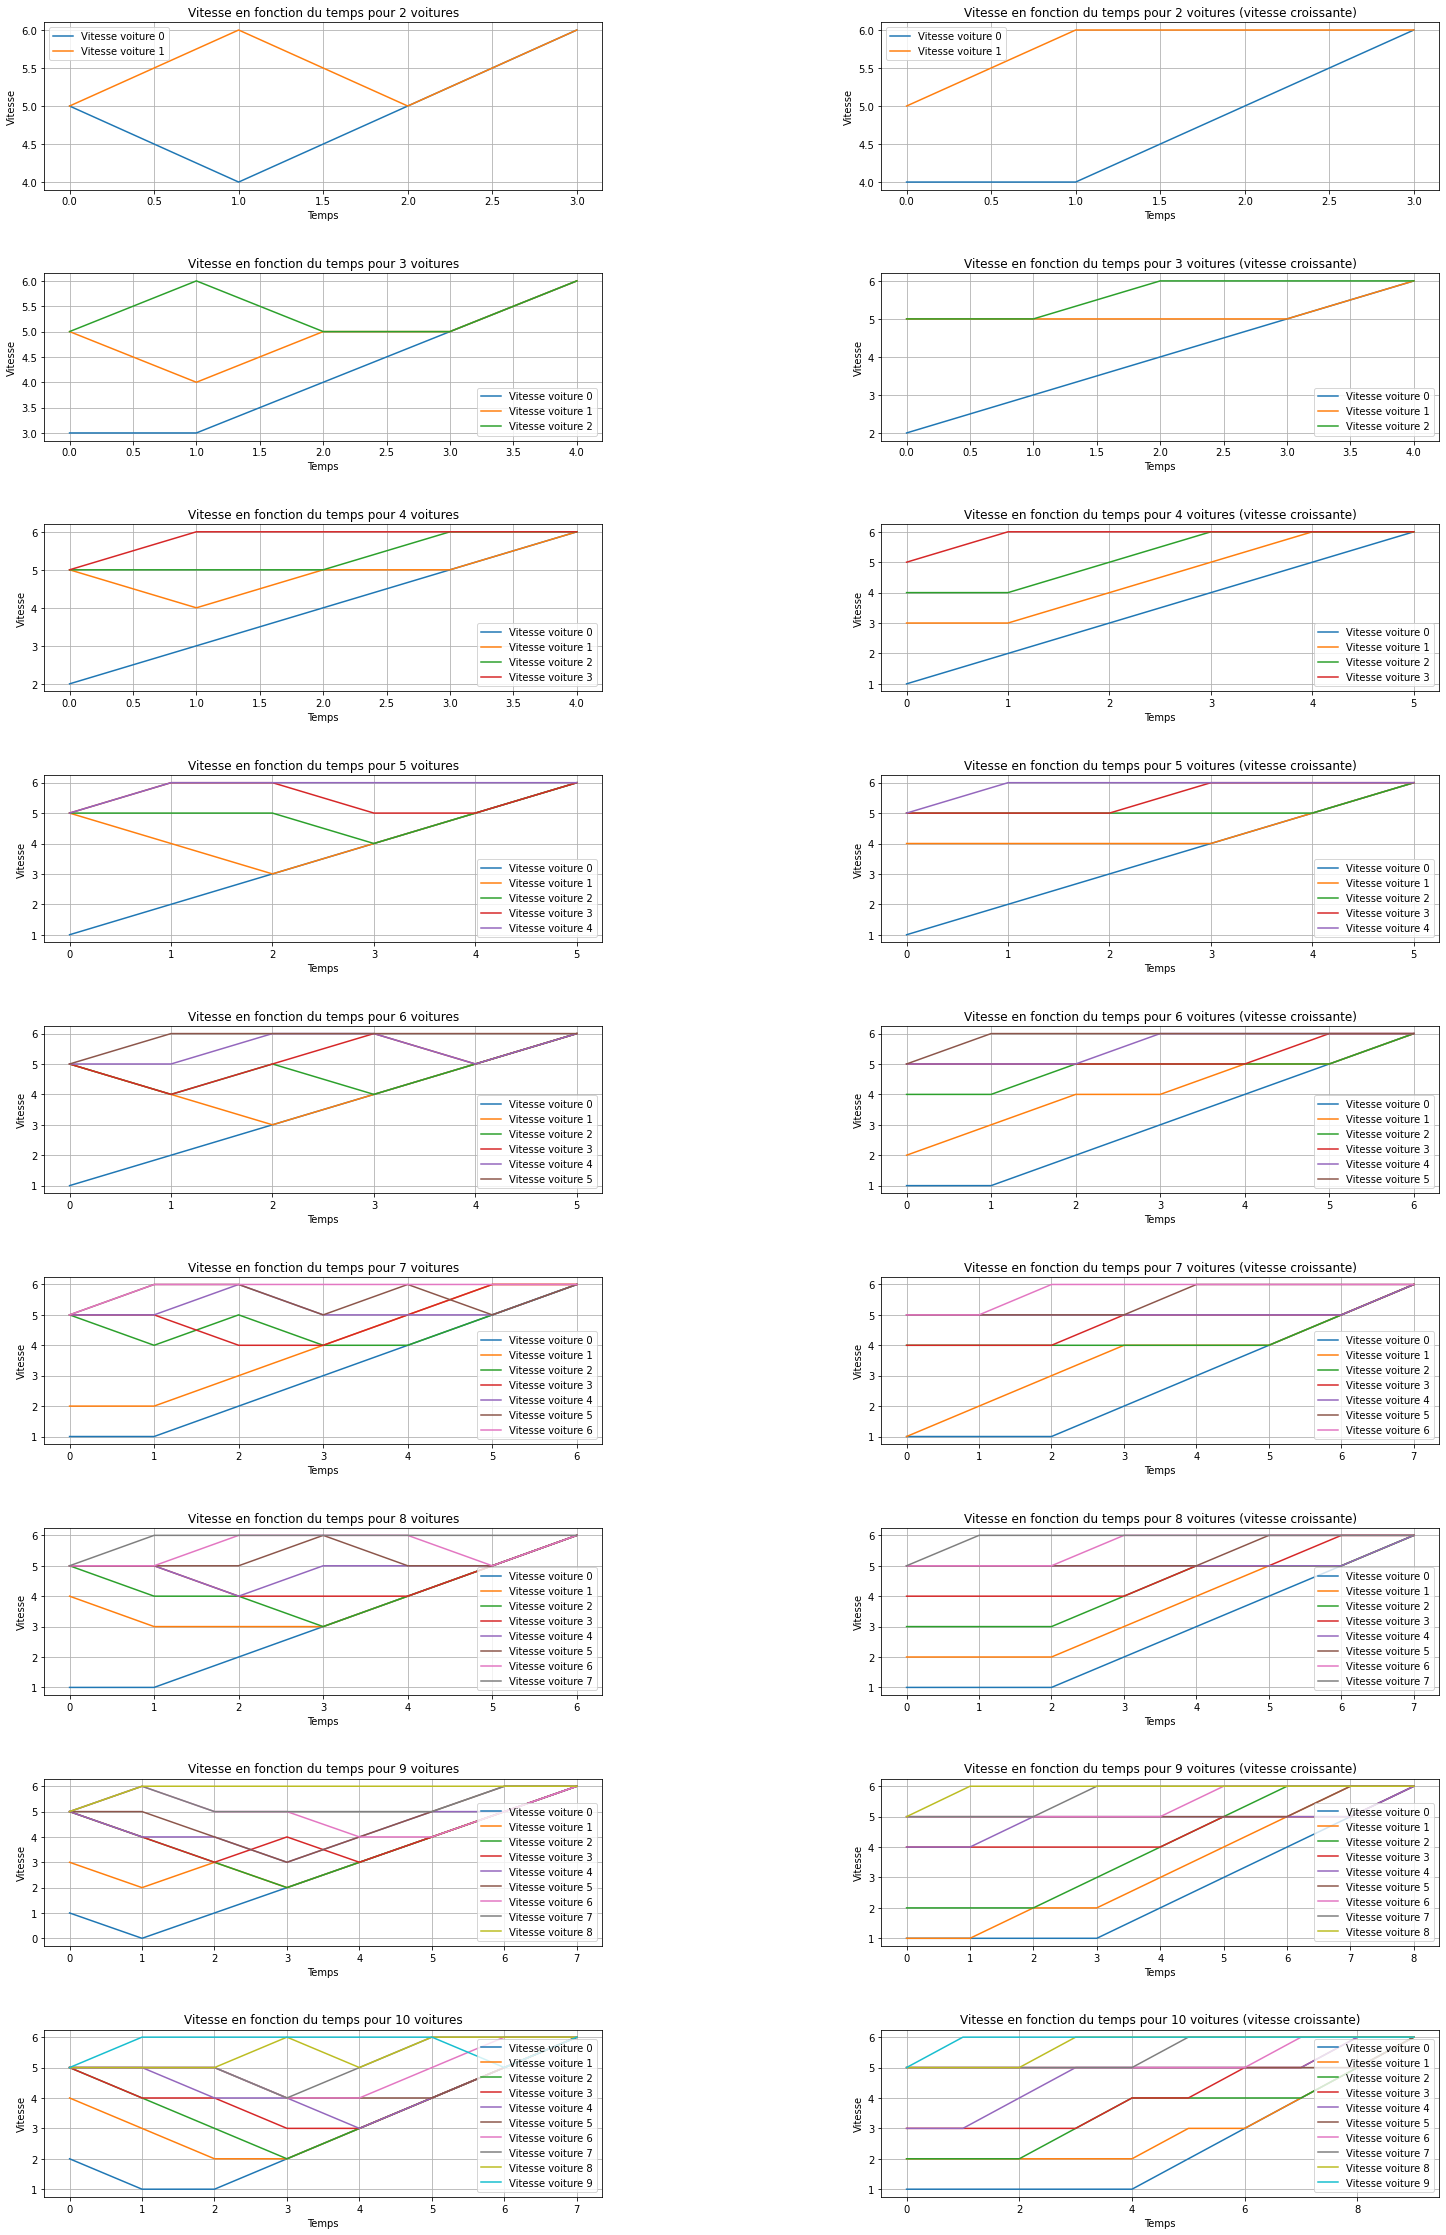

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 40))

for i in range(2, 11) :
    coord_x = []
    coord_y = []
    coord_x_bis = []
    coord_y_bis = []
    for j in range(len(dico_vitesses_voitures[i])) :
        coord_y_bis.append([])
        coord_x_bis = []
        for k in range(len(dico_vitesses_voitures[i][j])) :
            coord_x_bis.append(k)
            coord_y_bis[j].append(int(dico_vitesses_voitures[i][j][k].as_long()))
    
    for j in range(len(dico_vitesses_voitures_croissant[i])) :
        coord_y.append([])
        coord_x = []
        for k in range(len(dico_vitesses_voitures_croissant[i][j])) :
            coord_x.append(k)
            coord_y[j].append(int(dico_vitesses_voitures_croissant[i][j][k].as_long()))
    
    plt.subplot(9, 2, i * 2 - 3)
    
    for v in range(len(dico_vitesses_voitures[i])) :
        plt.plot(coord_x_bis, coord_y_bis[v], label=f"Vitesse voiture {v}")
                   
    plt.title(f"Vitesse en fonction du temps pour {i} voitures")      
    plt.xlabel("Temps")
    plt.ylabel("Vitesse")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(9, 2, i * 2 - 2)
    
    for v in range(len(dico_vitesses_voitures[i])) :
        plt.plot(coord_x, coord_y[v], label=f"Vitesse voiture {v}")
                   
    plt.title(f"Vitesse en fonction du temps pour {i} voitures (vitesse croissante)")      
    plt.xlabel("Temps")
    plt.ylabel("Vitesse")
    plt.legend()
    plt.grid(True)
    
    
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

---
### Comparaison de l'évolution du temps entre les deux codes (vitesse normale et vitesse croissante)

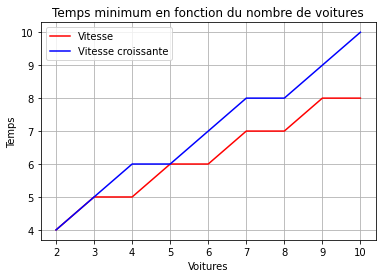

In [4]:
import numpy as np
import matplotlib.pyplot as plt

coord_x = []
coord_y = []
coord_x_bis = []
coord_y_bis = []
for cle, valeur in dico.items() :
    coord_x_bis.append(cle)
    coord_y_bis.append(valeur)
    
for cle, valeur in dico_vitesse_pas_restreint.items() :
    coord_x.append(cle)
    coord_y.append(valeur)
    
plt.plot(coord_x, coord_y, label="Vitesse", color="red")
plt.plot(coord_x_bis, coord_y_bis, label="Vitesse croissante", color="blue")
plt.title("Temps minimum en fonction du nombre de voitures")
plt.xlabel("Voitures")
plt.ylabel("Temps")
plt.legend()
plt.grid(True)

plt.show()

---
### Temps maximum selon les conditions initiales

On va inclure calculer le temps minimum pour résoudre le problème et ajouter la position initiale au solver afin qu'il trouve toutes les positions qui sont résolvables en ce temps. Ensuite, on va augmenter le temps et trouver d'autres positions qui satisfont nos comditions jusqu'à avoir la condition initiale la moins bonne possible.

> $compteur\_par\_temps[i][j][k]$ , avec $i$ pour le nombre de voitures totales, $j$ pour le temps et $k$ pour le nombre de solutions.

In [5]:
from z3 import *

#dico_vitesse_pas_restreint_max = {}
#dico_vitesses_voitures_max = {}
compteur_par_temps = {}
disposition_max = {}
for k in range(2, 6) :
    #dico_vitesse_pas_restreint_max[k] = 100000000
    #dico_vitesses_voitures_max[k] = {}
    compteur_par_temps[k] = {}
    #for m in range(k) :
        #dico_vitesses_voitures_max[k][m] = {}
    blocks = []
    temps_min = coord_y[k - 2]
    for l in range(temps_min - 1, temps_min + 10) :
        compteur_par_temps[k][l] = 0
        #n voitures et t temps max
        n = k
        t = l

        #Variables
        vmax = 6

        s = [[Int('s_{}_{}'.format(i, j)) for j in range(t)] for i in range(n)] #vitesse_[voiture]_[temps]
        pos = [[Int('pos_{}_{}'.format(i, j)) for j in range(t)] for i in range(n)] #position_[voiture]_[temps]

        df = [[Int('df_{}_{}'.format(i, j)) for j in range(t)] for i in range(n)] #distance freinage_[voiture]_[temps]

        #distance entre 2 voitures (de i à j) au temps k
        d = [[[Int('d_{}_{}_{}'.format(i, j, k)) for k in range(t)] for j in range(n)] for i in range(n)] 


        #Solver
        solver = Solver()

        #condition initiale
        for i in range(n) :
            solver.add(pos[0][0] == 0) #1ere voiture à la 1ere position
            solver.add(pos[i][0] >= 0) #position initiale positive
            solver.add(s[i][0] >= 0, s[i][0] <= vmax - 1) #vitesse initiale bornée
            solver.add(df[i][0] == (s[i][0] * (s[i][0] + 1)) / 2) #distance freinage

        #Modifations de vitesses et positions
        for time in range(1, t) :
            for i in range(n) :
                #vitesse toujours bornée
                solver.add(s[i][time] >= 0, s[i][time] <= vmax)
                #modification de la vitesse (+/- 1 ou constante)
                solver.add( Or( s[i][time] == s[i][time - 1],
                                  s[i][time] == s[i][time - 1] + 1,
                                  s[i][time] == s[i][time - 1] - 1)) 

                solver.add(pos[i][time] == pos[i][time-1] + s[i][time-1]) #position = pos(t-1) + vitesse(t-1)
                solver.add(df[i][time] == (s[i][time] * (s[i][time] + 1)) / 2) #distance freinage


        #calcul distance entre voitures + conditions à satisfaire
        for time in range(t) :
            for i in range(n - 1) :
                solver.add( pos[i][time] < pos[i + 1][time] ) #si i<j alors i est derrière j
                #calcul d'écart entre les voitures 
                solver.add( d[i][i + 1][time] == pos[i + 1][time] - pos[i][time] - 1)

                #conditions à satisfaire en tout temps
                solver.add( d[i][i + 1][time] + df[i + 1][time] >= df[i][time] ) #distance de sécurité



        #conditions finales
        for i in range(n) :
            if (i != n - 1) :
                #ajoute la condition initiale si i est derrière j (rien autrement)
                solver.add( s[i][0] > d[i][i + 1][0] ) #condition initial ne satisfait pas la condition final

                solver.add( s[i][t-1] <= d[i][i + 1][t-1] ) #au temps final

            #ajoute la condition finale d'une vitesse max
            solver.add( s[i][t-1] == vmax )

        # On rajoute les positions initiales des solutions précédentes
        if (len(blocks) > 0) :
            for elem in blocks :
                solver.add( Not ( And ( elem )))
        #print(solver)
        
        while solver.check() == sat :
            model = solver.model()
            #print(model)
            #print(f"{k} voitures au temps {l}")
            b = []
            for d in model :
                if (str(d).endswith("_0")) : #changer que les positions initiales
                    cp = model[d] == d()
                    #print(cp)
                    #print("\n")
                    b.append(cp)
            #print("----")

            # pour conserver une trace pour les temps suivants
            blocks.append(b)
            solver.add( Not ( And ( b )))
            #print(solver.check() == sat)
            #print("\n\n")
            compteur_par_temps[k][l] += 1
        
        if (len(blocks) > 0) :
            disposition_max[k] = blocks[-1]
"""
            # Obtenir les variables du modèle
            variables = model.decls()

            # Trier les variables par leur nom
            sorted_variables = sorted(variables, key = lambda v : v.name())

            # Afficher les valeurs des variables dans l'ordre
            #print(f"\n\nPour {k} voitures : \n")
            for var in sorted_variables :
                #print(f"{var.name()} : {model[var]}")
                if (var.name()[:2] == "s_") :
                    if (len(var.name()) == 5) :
                        dico_vitesses_voitures_max[k][int(var.name()[2])][int(var.name()[4])] = model[var]
                    else :
                        dico_vitesses_voitures_max[k][int(var.name()[2])][int(var.name()[4:5])] = model[var]
            
            dico_vitesse_pas_restreint_max[k] = l
            
"""

            
print(compteur_par_temps)

{2: {3: 0, 4: 6, 5: 15, 6: 10, 7: 3, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0}, 3: {4: 0, 5: 29, 6: 128, 7: 68, 8: 12, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0}, 4: {4: 0, 5: 3, 6: 221, 7: 845, 8: 401, 9: 35, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0}, 5: {5: 0, 6: 66, 7: 1751, 8: 5212, 9: 1823, 10: 132, 11: 1, 12: 0, 13: 0, 14: 0, 15: 0}}


Pour 2 voitures :
6 solutions en 4 temps
15 solutions en 5 temps
10 solutions en 6 temps
3 solutions en 7 temps
1 solutions en 8 temps

Pour 3 voitures :
29 solutions en 5 temps
128 solutions en 6 temps
68 solutions en 7 temps
12 solutions en 8 temps
1 solutions en 9 temps

Pour 4 voitures :
3 solutions en 5 temps
221 solutions en 6 temps
845 solutions en 7 temps
401 solutions en 8 temps
35 solutions en 9 temps
1 solutions en 10 temps

Pour 5 voitures :
66 solutions en 6 temps
1751 solutions en 7 temps
5212 solutions en 8 temps
1823 solutions en 9 temps
132 solutions en 10 temps
1 solutions en 11 temps



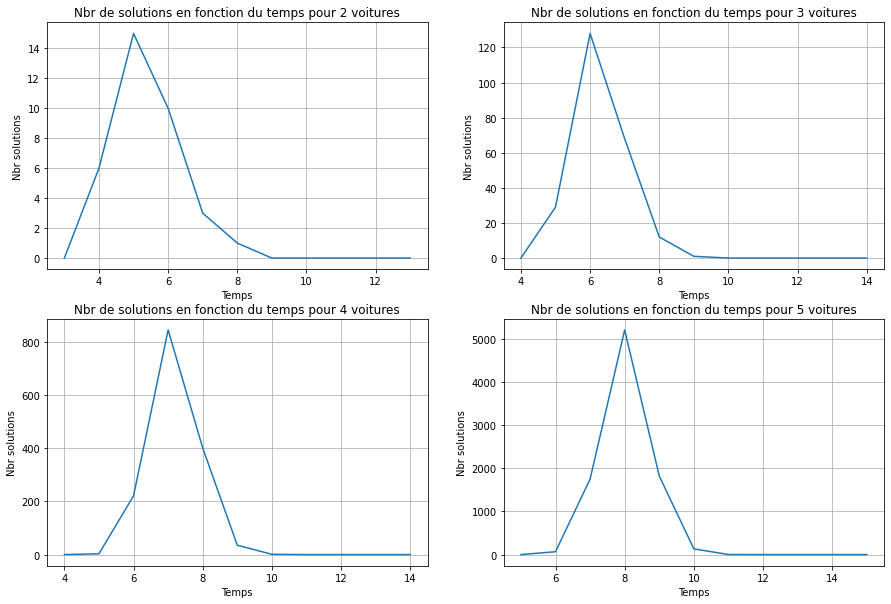

Le temps pour 2 voitures est : min 4 temps, max 8 temps
Le temps pour 3 voitures est : min 5 temps, max 9 temps
Le temps pour 4 voitures est : min 5 temps, max 10 temps
Le temps pour 5 voitures est : min 6 temps, max 11 temps


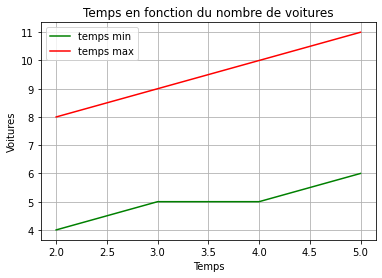

In [7]:
max_par_voiture = {}
plt.figure(figsize=(15, 10))

for i in compteur_par_temps :
    print(f"Pour {i} voitures :")
    plt.subplot(2, 2, i - 1)
    plt.plot(list(compteur_par_temps[i].keys()), list(compteur_par_temps[i].values()))
    plt.title(f"Nbr de solutions en fonction du temps pour {i} voitures")      
    plt.xlabel("Temps")
    plt.ylabel("Nbr solutions")
    plt.grid(True)
    
    
    for j in compteur_par_temps[i] :
        if (compteur_par_temps[i][j] != 0) :
            max_par_voiture[i] = j
            print(f"{compteur_par_temps[i][j]} solutions en {j} temps")
            
    print()
    
    
plt.show()

voitures = []
temps_max_voitures = []
for i,j in max_par_voiture.items() :
    voitures.append(i)
    temps_max_voitures.append(j)
    print(f"Le temps pour {i} voitures est : min {coord_y[i - 2]} temps, max {j} temps")
    
plt.plot(voitures, coord_y[:len(voitures)], label="temps min", color="green")
plt.plot(voitures, temps_max_voitures, label="temps max", color="red")
plt.title("Temps en fonction du nombre de voitures")      
plt.xlabel("Temps")
plt.ylabel("Voitures")
plt.legend()
plt.grid(True)

plt.show()

### Visualisation des dispositions initiales pour le temps max

In [30]:
for v, dispo in disposition_max.items() :
    print(f" Pour {v} voitures :")
    for cond in dispo :
        print(cond)

 Pour 2 voitures :
1 == df_1_0
0 == d_0_1_0
1 == df_0_0
0 == pos_0_0
1 == pos_1_0
1 == s_0_0
1 == s_1_0
 Pour 3 voitures :
0 == pos_0_0
1 == s_0_0
1 == df_2_0
0 == d_1_2_0
1 == pos_1_0
1 == df_1_0
2 == pos_2_0
1 == df_0_0
1 == s_2_0
0 == d_0_1_0
1 == s_1_0
 Pour 4 voitures :
1 == s_0_0
0 == d_1_2_0
2 == pos_2_0
0 == pos_0_0
1 == s_1_0
1 == df_1_0
1 == pos_1_0
3 == pos_3_0
0 == d_2_3_0
1 == s_3_0
0 == d_0_1_0
1 == s_2_0
1 == df_2_0
1 == df_3_0
1 == df_0_0
 Pour 5 voitures :
1 == pos_1_0
1 == s_2_0
2 == pos_2_0
0 == pos_0_0
1 == s_1_0
3 == pos_3_0
1 == df_4_0
0 == d_0_1_0
4 == pos_4_0
0 == d_2_3_0
1 == s_3_0
0 == d_3_4_0
1 == df_3_0
0 == d_1_2_0
1 == df_1_0
1 == s_4_0
1 == df_0_0
1 == df_2_0
1 == s_0_0


Pour le visuel, $v_i$ indique le véhicule numéro $i$ et $s_j$ la vitesse $j$ de ce véhicule

In [33]:
def grill() :
    print("Sens du mouvement ---->\n")
    print("case_0   |   case_1   |   case_2   |   case_3   |   case_4   |   case_5   |   case_6   |   case_7   |   case_8   |")

def posvit(pos, vit) :
    affichage = ""
    for i in pos :
        texte = ""
        if (i != -1) :
            texte = f"v{i}, s{vit[i]}   |   "
        else :
            texte = "   -     |   "
        affichage += texte
    print(affichage)
    
for v, dispo in disposition_max.items() :
    position = [-1 for x in range(9)]
    vitesse = [-1 for x in range(v)]
    vitesse.append("")
    print(f"\nPour {v} voitures :\n")
    grill()
    for cond in dispo :
        if (str(cond)[5:10].startswith("pos")) :
            position[int(str(cond)[0])] = int(str(cond)[9])
        elif (str(cond)[5:10].startswith("s")) :
            vitesse[int(str(cond)[7])] = int(str(cond)[0])
    posvit(position, vitesse) 
    print()
    


Pour 2 voitures :

Sens du mouvement ---->

case_0   |   case_1   |   case_2   |   case_3   |   case_4   |   case_5   |   case_6   |   case_7   |   case_8   |
v0, s1   |   v1, s1   |      -     |      -     |      -     |      -     |      -     |      -     |      -     |   


Pour 3 voitures :

Sens du mouvement ---->

case_0   |   case_1   |   case_2   |   case_3   |   case_4   |   case_5   |   case_6   |   case_7   |   case_8   |
v0, s1   |   v1, s1   |   v2, s1   |      -     |      -     |      -     |      -     |      -     |      -     |   


Pour 4 voitures :

Sens du mouvement ---->

case_0   |   case_1   |   case_2   |   case_3   |   case_4   |   case_5   |   case_6   |   case_7   |   case_8   |
v0, s1   |   v1, s1   |   v2, s1   |   v3, s1   |      -     |      -     |      -     |      -     |      -     |   


Pour 5 voitures :

Sens du mouvement ---->

case_0   |   case_1   |   case_2   |   case_3   |   case_4   |   case_5   |   case_6   |   case_7   |   case_8   |
v0,